<a href="https://www.kaggle.com/code/adri1g/predict-solar-irradiance-with-gradient-boosting?scriptVersionId=185069245" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predict solar irradiance (GHI)
Also call GHI (Global Horizontal Irradiance), in W/m². This is the target feature (y) used to predict electricity generation (W) from solar panels.

$$
GHI = DNI * cos(\theta) + DHI
$$

$\theta$ : incidence of the solar beam

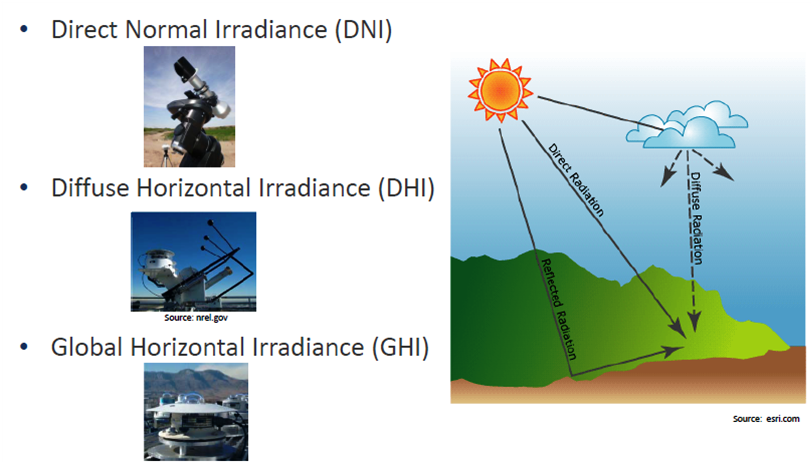

From : https://firstgreenconsulting.wordpress.com/2012/04/26/differentiate-between-the-dni-dhi-and-ghi/

We will be using a dataset from the NSRDB, satellite meteorological measurements.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from scipy import stats

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)
from tqdm import tqdm # monitor loop

# Import weather files

In [2]:
print("File location using os.getcwd():", os.getcwd())

# default path for local execution on PC
PATH = 'nsrdb-tours/' # input folder
WORK_DIR = PATH  # output folder

if "google.colab" in str(get_ipython()):
    print("Running on CoLab")
    PATH = "/content/drive/My Drive/Colab Notebooks/time_series/"  # input
    WORK_DIR = PATH  # output

    # mount like on Linux
    from google.colab import drive

    drive.mount("/content/drive")

elif "kaggle" in str(os.getcwd()):
    PATH = "/kaggle/input/nsrdb-tours/"  # input
    WORK_DIR = "/kaggle/working/darts_logs/"  # output
    from learntools.time_series.utils import *
    from learntools import *
    
else: # on local PC
    from ds_utils import *
    from ds_time_series import *

File location using os.getcwd(): /kaggle/working


## Concatenate and convert datetime to index

In [3]:
# Initialize an empty list to hold DataFrames
dfs = []

# Loop over all files in the folder
for file_name in os.listdir(PATH):
    if file_name.startswith('359516_') and file_name.endswith('.csv'):
        # Create the full file path
        file_path = os.path.join(PATH, file_name)
        #print(f'Reading {file_path}')
        
        # Read the CSV file
        df = pd.read_csv(file_path, skiprows=2)
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list into a whole dataset
df = pd.concat(dfs)

# Generate a datetime index column
df['datetime'] = pd.to_datetime(df['Year'].astype(str) +'-'
                                + df['Month'].astype(str) + '-'
                                + df['Day'].astype(str) + ' '
                                + df['Hour'].astype(str) + ':'
                                + df['Minute'].astype(str) + ':00')

# Drop useless columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

# Set datetime as index
df = df.set_index('datetime')

# accelerate processing by reducing information
# df = df.astype(np.float32)

df.info()  # check dataframe info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105120 entries, 2017-01-01 00:00:00 to 2019-12-31 23:45:00
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Temperature         105120 non-null  float64
 1   Clearsky DHI        105120 non-null  int64  
 2   Clearsky DNI        105120 non-null  int64  
 3   Clearsky GHI        105120 non-null  int64  
 4   Cloud Type          105120 non-null  int64  
 5   Dew Point           105120 non-null  float64
 6   DHI                 105120 non-null  int64  
 7   DNI                 105120 non-null  int64  
 8   Fill Flag           105120 non-null  int64  
 9   GHI                 105120 non-null  int64  
 10  Ozone               105120 non-null  float64
 11  Relative Humidity   105120 non-null  float64
 12  Solar Zenith Angle  105120 non-null  float64
 13  Surface Albedo      105120 non-null  float64
 14  Pressure            105120 non-null  int64  
 15  

## Time step

In [4]:
print("Time step:", pd.infer_freq(df.index))
ONE_HOUR = 4 # 1 hour is 4 time step of 15 minutes

Time step: 15min


## Category completion

In [5]:
# Rename the values in the "Cloud Type" column
cloud_type_mapping = {
   0:  'Clear',
   1:  'Probably Clear',
   2:  'Fog',
   3:  'Water',
   4:  'Super-Cooled Water',
   5:  'Mixed',
   6:  'Opaque Ice',
   7:  'Cirrus',
   8:  'Overlapping',
   9:  'Overshooting',
   10: 'Unknown',
   11: 'Dust',
   12: 'Smoke',
   -15:'N/A',
}
df['Cloud Type Name'] = df['Cloud Type'].map(cloud_type_mapping)

fill_flag_mapping = {
    0: 'N/A',
    1: 'Missing Image',
    2: 'Low Irradiance',
    3: 'Exceeds Clearsky',
    4: 'Missing Cloud Properties',
    5: 'Rayleigh Violation'
}

df['Fill Flag Name'] = df['Fill Flag'].map(fill_flag_mapping)

# Features engineering
* y: target to predict (GHI)
* X: features used to predict y

Determine which features to use in X.

## Solar zenith and altitude angle

We use deterministic astronomical data to obtain forwards information on the angular altitude of the sun during the day and during the year.

* Zenith angle, between the sun’s rays and the vertical direction
* Altitude angle from 0 (no sun) to 90

Get solar angle: https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.solarposition.get_solarposition.html

<img src="https://www.mdpi.com/sensors/sensors-21-06259/article_deploy/html/images/sensors-21-06259-g002.png" alt= “” width="750" height="value">

CC BY 4.0 Zhang et al.
DOI:10.3390/s21186259

https://nsrdb.nrel.gov/data-sets/us-data

In [6]:
#rotation to convert from zenith angle to solar altitude
df['Solar Altitude Angle'] = 90 - df['Solar Zenith Angle']

#the sun is down when the angle is under 0 (the horizon)
df.loc[df['Solar Altitude Angle'] <= 0, 'Solar Altitude Angle'] = 0

#determine periods of sunlight from the solar position
daylight = df['Solar Zenith Angle'] <= 90
# convert to int to use with various prediction model
df["daylight"] = (daylight).astype(int)

### Day light per month
Use boxplot to vizualise solar irradiance (GHI) per month.

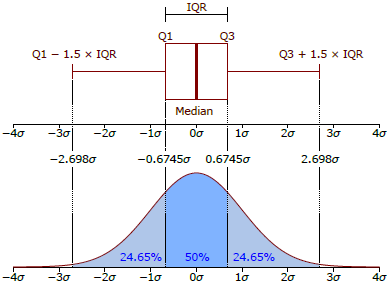

IQR: inter quartile range

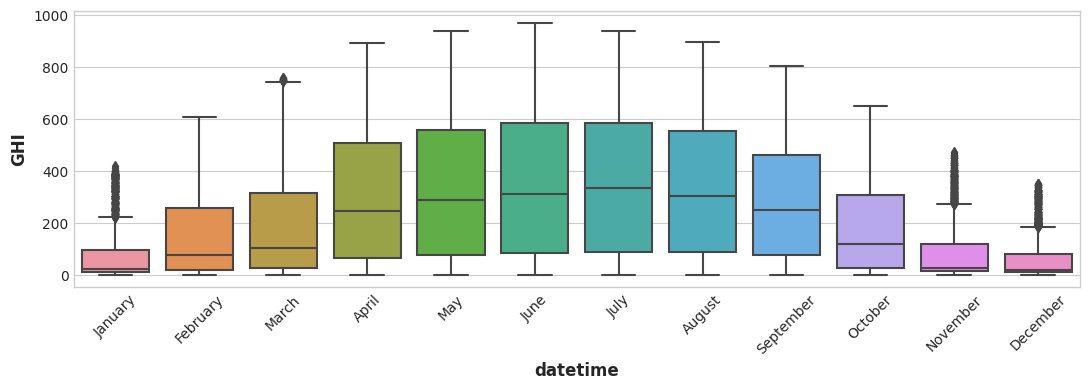

In [7]:
sns.boxplot(x=df[daylight].index.month_name(), y='GHI', data=df[daylight])
plt.xticks(rotation=45)
plt.show()

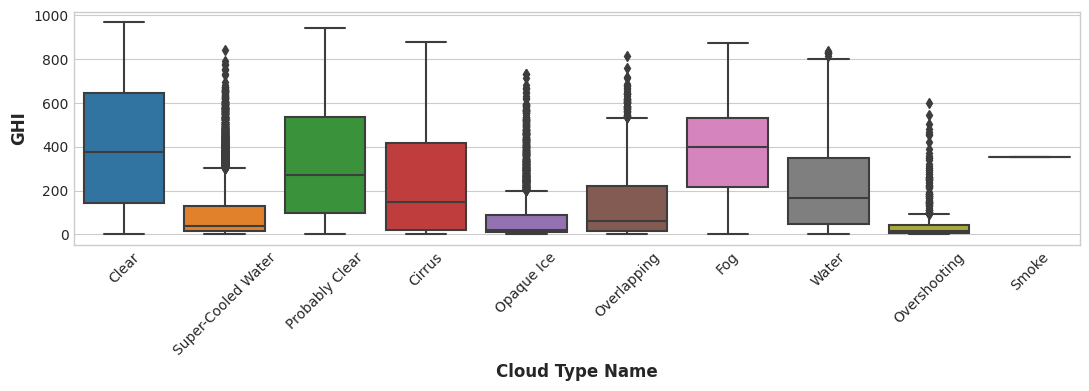

In [8]:
sns.boxplot(x='Cloud Type Name', y='GHI', data=df[daylight])
plt.xticks(rotation=45)
plt.show()

The cloud cover determined by satellite does not appear to have an high impact on the GHI, and more important, this feature is absent in production.

## Mutual information for GHI

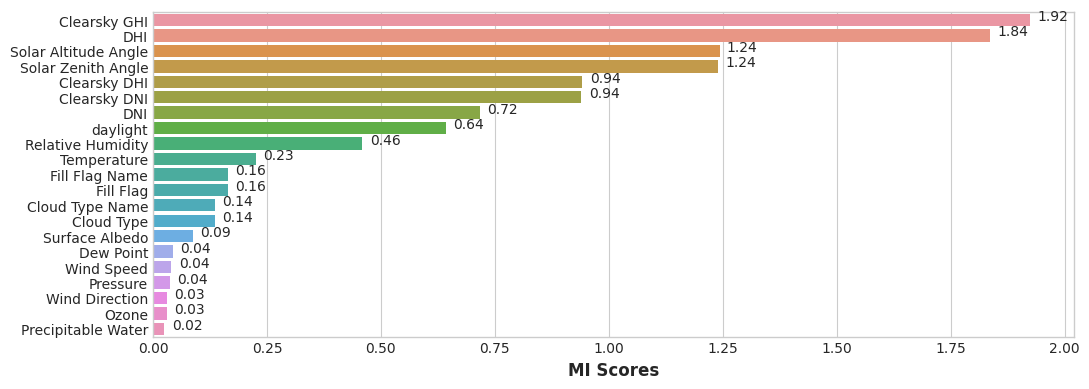

In [9]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Compute mutual information scores for features in X relative to target y.
    Example:
    make_mi_scores(df.drop("y", axis=1), df["y"])
    """
    from sklearn.feature_selection import mutual_info_regression
    
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=0
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

def plot_scores(scores: pd.Series, score_type: str):
    scores = scores.sort_values(ascending=False)  # Seaborn prefers this orientation
    sns.barplot(x=scores, y=scores.index)

    if score_type == "mi":
        plt.xlabel("Mutual Information Scores")
    elif score_type == "corr":
        plt.xlabel("Correlation Scores")

    # Add a text label to each bar with the corresponding score
    for i, score in enumerate(scores):
        plt.text(score + 0.05, i, f"{score:.2f}", ha="center")

mi_scores = make_mi_scores(df.drop("GHI", axis=1), df["GHI"])
plot_scores(mi_scores, "Mutual Information Scores")

#https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html

Solar angle and daylight from astronomical parameters are strongly related to GHI. Humidity and Temperature are less related to GHI.

## Correlation between GHI and features

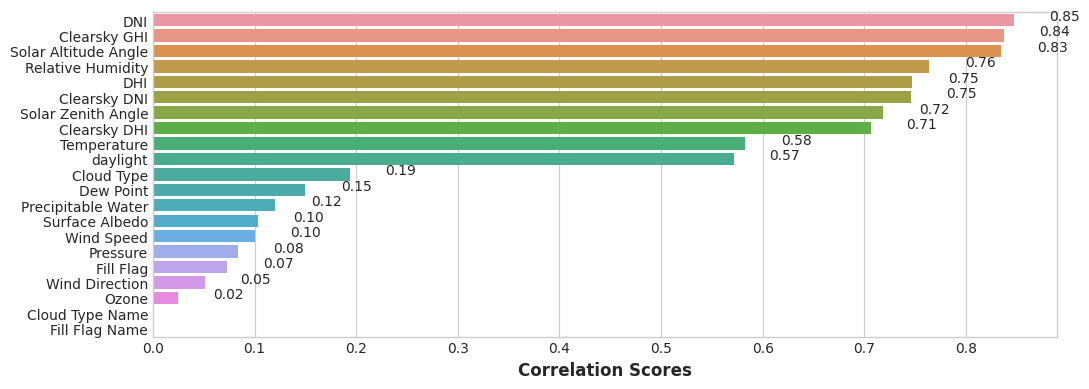

In [10]:
def make_corr_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Compute correlation scores for features in X relative to target y."""
    # Check the data types of the columns in X and y
    X_numeric = X.select_dtypes(include=['number'])
    y_numeric = y.to_frame().select_dtypes(include=['number'])

    # If y is not numeric, raise an error
    if y_numeric.empty:
        raise ValueError("Target variable y must be numeric")

    # Compute the correlation scores for the numeric columns in X
    corr_scores = X_numeric.corrwith(y_numeric.iloc[:,0])
    corr_scores = pd.Series(corr_scores, name="Correlation Scores", index=X.columns)
    corr_scores = corr_scores.abs().sort_values(ascending=False)
    return corr_scores

corr_scores = make_corr_scores(df.drop("GHI", axis=1), df["GHI"])
plot_scores(corr_scores, "corr")

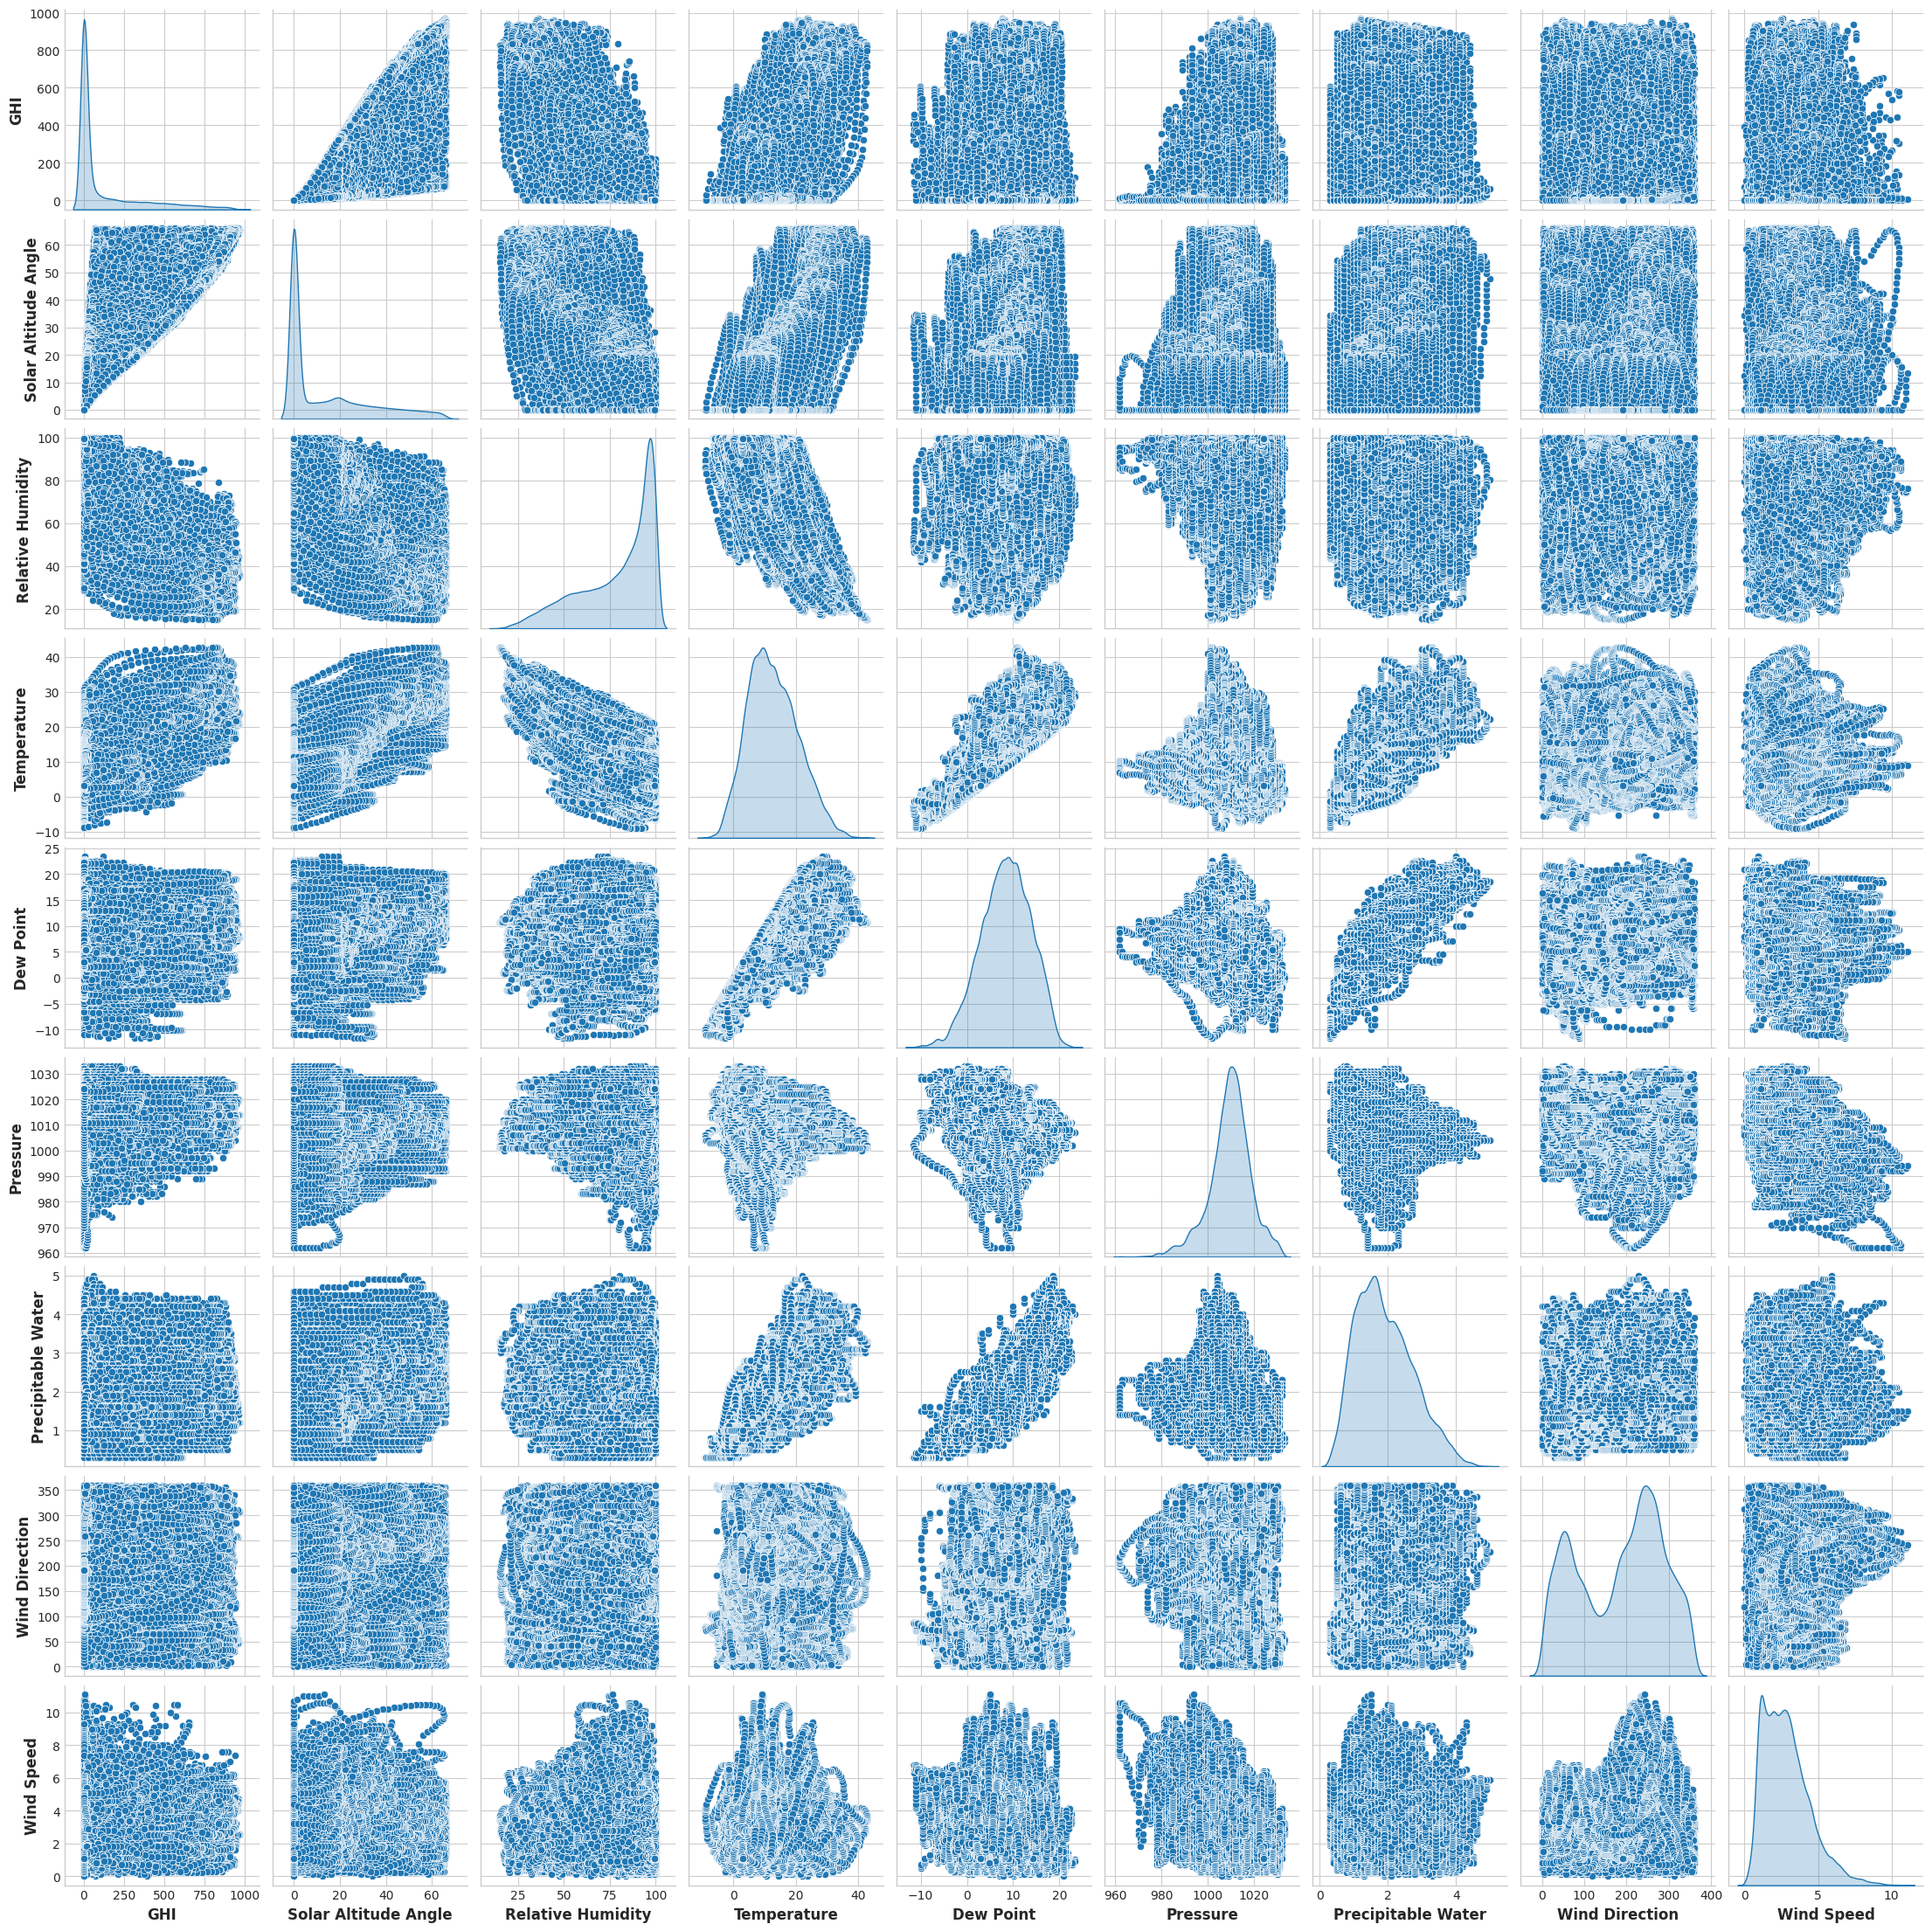

In [11]:
sns.pairplot(df[[
    "GHI",
    "Solar Altitude Angle",
    "Relative Humidity",
    "Temperature",
    "Dew Point",
    "Pressure",
    "Precipitable Water",
    "Wind Direction",
    "Wind Speed",
]], 
             diag_kind="kde"
             #, corner=True
            )

## Create Fourier features from solar altitude angle

In [12]:
# creates a non-ambiguous feature (a pair of values for each angle) that can be interpreted by the models
df["sin_solar_altitude"] = np.sin(df["Solar Altitude Angle"] * np.pi / 180)
df["cos_solar_altitude"] = np.cos(df["Solar Altitude Angle"] * np.pi / 180)

## Seasonality

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

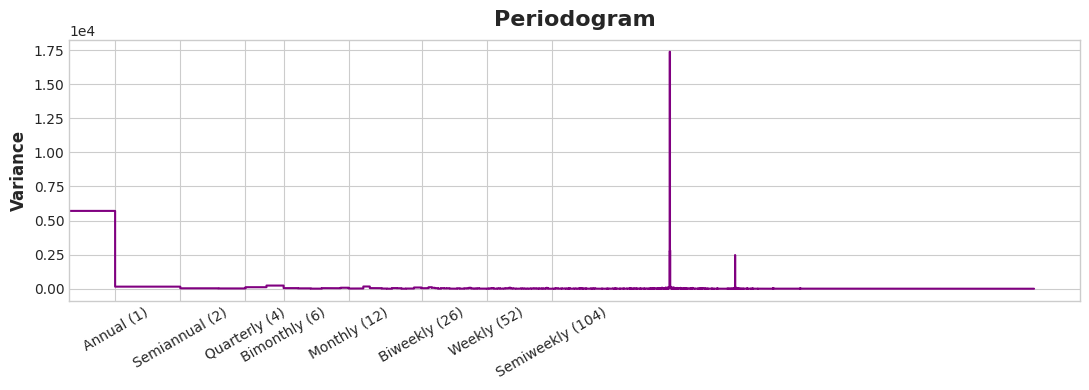

In [13]:
def plot_periodogram(
    ts, fs=pd.Timedelta("365D") / pd.Timedelta("1D"), detrend="linear", ax=None
):
    # Import the periodogram function from the scipy.signal module
    from scipy.signal import periodogram

    # Calculate the sampling frequency: the number of samples per unit of time
    # In this case, the unit of time is 1 day, and the number of samples is 365 days (1 year)

    # The scaling argument is used to specify the type of scaling to apply to the periodogram
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,  # sampling frequency, the number of samples per unit of time
        detrend=detrend,
        window="boxcar",  # the type of window function to apply to the time series
        scaling="spectrum",  # the type of scaling to apply to the periodogram
    )

    # If ax is not provided, create a new subplot
    if ax is None:
        _, ax = plt.subplots()

    # Plot the periodogram: x=frequencies, y=spectrum
    # The step function is used to create a step plot, which is a type of plot that shows the change in a value over a certain period of time
    ax.step(frequencies, spectrum, color="purple")

    # Set the x-axis to a logarithmic scale
    ax.set_xscale("log")

    # Set the x-axis ticks and labels
    # The ticks are the values at which the labels are placed
    # The labels are the text that is displayed at the ticks
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,  # the angle of rotation of the labels
    )

    # Set the y-axis labels to display in scientific notation
    ax.ticklabel_format(
        axis="y", style="sci", scilimits=(0, 0)
    )  # the range of values to display in scientific notation

    # Set the y-axis label
    ax.set_ylabel("Variance")

    # Set the title of the plot
    ax.set_title("Periodogram")

    # Return the axes object
    return ax
plot_periodogram(df["GHI"][:365*24*ONE_HOUR].values, 365*24*ONE_HOUR)

Annual seasonality is important at ordre 1 like daily seasonality at order 1, no need of additional fourier features.

We create an annual and daily seasonality Fourier features with statsmodels

In [14]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourierYear = CalendarFourier(freq="A", order=1)  # sin/cos pairs for Annual seasonality
fourierDay = CalendarFourier(freq="D", order=1)  # sin/cos pairs for daily seasonality

dp = DeterministicProcess(
    index=df["GHI"].index,
    #period=24*4,
    #constant=True,               # dummy feature for bias (y-intercept)
    #order=1,                     # trend (order 1 means linear)
    #seasonal=True,               # daily seasonality from period (indicators)
    additional_terms=[fourierYear],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_years = dp.in_sample()  # create features for dates in tunnel.index


dp = DeterministicProcess(
    index=df["GHI"].index,
    additional_terms=[fourierDay],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_days = dp.in_sample()  # create features for dates in tunnel.index

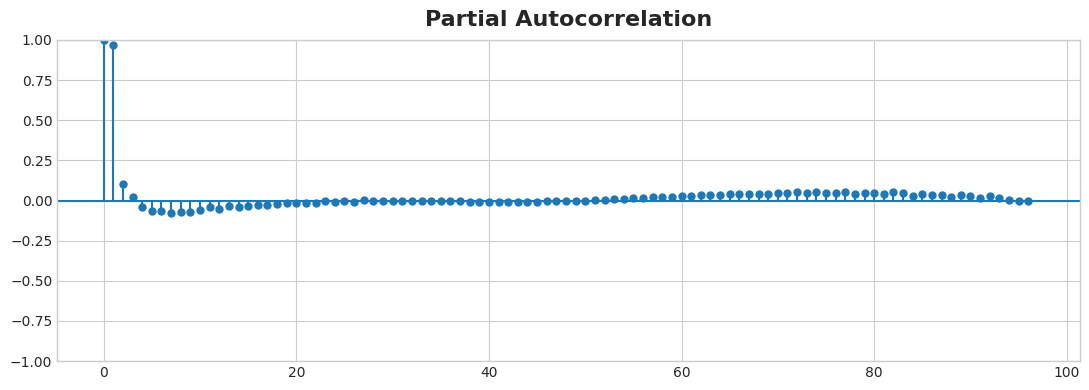

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["GHI"], lags=24*ONE_HOUR);

## Select astronimical and weather features

In [16]:
#select only astronomical features
features_astronomical = [
    "sin_solar_altitude", # Solar Altitude Angle
    "cos_solar_altitude", # Solar Altitude Angle
    "daylight",
]

#select only weather features
features_weather = [
    "Relative Humidity",
    "Temperature",
    "Dew Point",
    "Pressure",
    "Precipitable Water",
    "Wind Direction",
    "Wind Speed",
]

## Build lags, leads features and multistep target

In [17]:
y = df["GHI"]

HORIZON_LAGS = ONE_HOUR * 3 # 1 hour
HORIZON_LEADS = ONE_HOUR * 3 # 1 hour #WARNING: large value have a huge impact on computing time for models using RegressorChain

#past values of target y
y_lags = make_lags(y, lags=HORIZON_LAGS).bfill()

#futures values from astronomy
X_leads = make_leads(df[features_astronomical], leads=HORIZON_LEADS)

# make y multistep
y = make_multistep_target(y, steps=HORIZON_LEADS).dropna()

## Feature using measurements averaged over the last n days

<Axes: xlabel='datetime'>

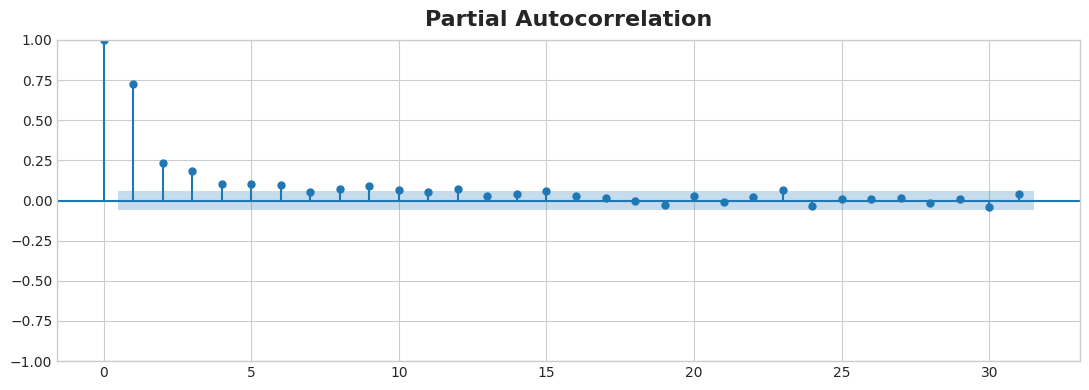

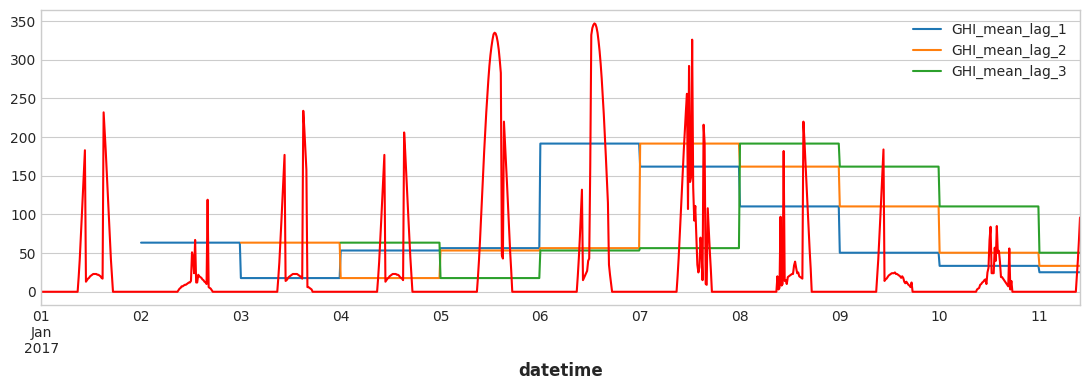

In [18]:
#create lags with the average value of previous days

# Resample to daily frequency and filter based on daylight condition
GHI_mean_day = y.iloc[:,0][df["daylight"]==1].resample('D').mean()
GHI_mean_day = GHI_mean_day.rename('GHI_mean_day')

plot_pacf(GHI_mean_day);

X_lags_mean = make_lags(GHI_mean_day, lags=3, name="GHI_mean") # make lags of mean, on PACF, the effect of the time lags is not significant after some days
df_dummy = pd.DataFrame(y.index).set_index("datetime") # define a dummy df to restore previous index
X_lags_mean = pd.concat([X_lags_mean, df_dummy], axis=1) # restore previous time step, but one GHI mean per day
X_lags_mean = X_lags_mean.ffill() # forward fill from the unique value per day
#TODO: try moving average

ax = X_lags_mean[:1000].plot()
pd.Series(y.iloc[:,0][:1000]).plot(ax=ax, color='red')

## Clustering data to extract label and cluster distance as additional features
Try to extract some features by clustering weather and astronomical data

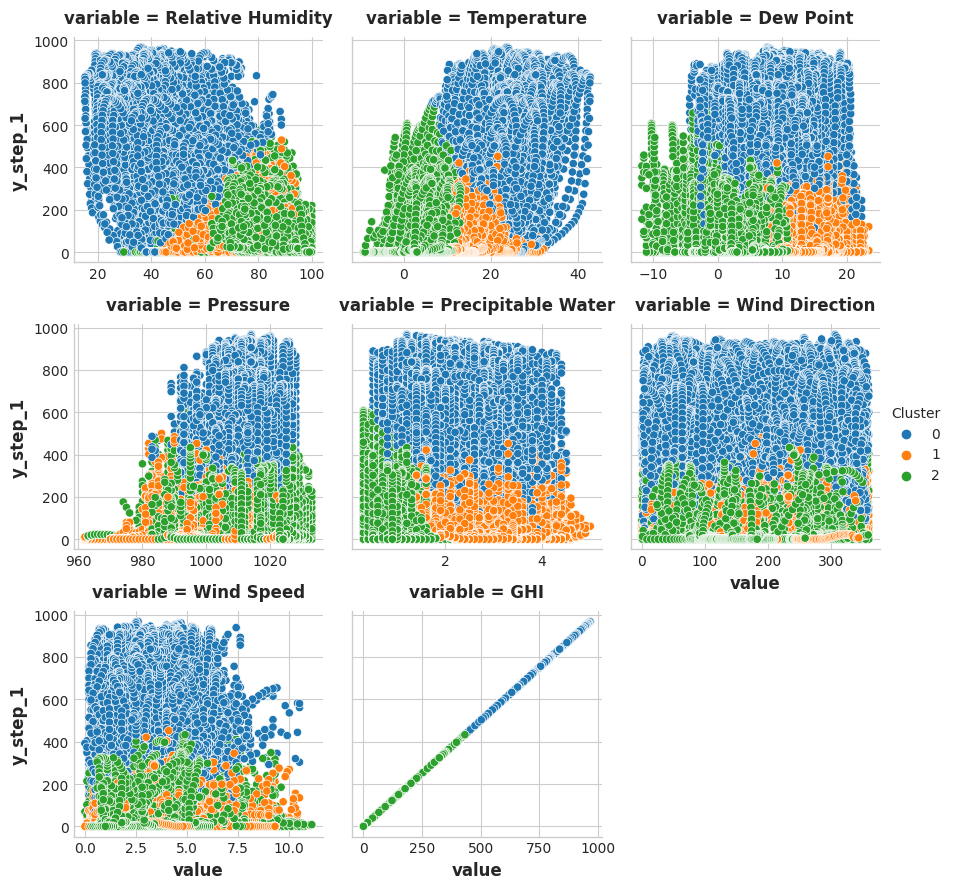

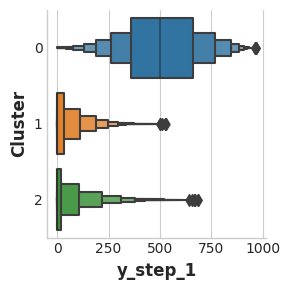

In [19]:
#make features with clustering
#WARNING: data leakage because the whole dataset is used to clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Xy = df[features_weather + ["GHI"]]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(Xy.values), columns=Xy.columns)

# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=3, random_state=None)  # , n_init=10
Xy["Cluster"] = kmeans.fit_predict(X_scaled.values)

# Convert Cluster to category
Xy["Cluster"] = Xy["Cluster"].astype("category")

X_cd = kmeans.transform( #clusters distance
    X_scaled.values
)  # each row contains the distance to each centroid
# Label features and join to dataset
columns_centroid = [f"Centroid_{i}" for i in range(X_cd.shape[1])]
X_cd = pd.DataFrame(
    X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])], index=Xy.index
)

Xy[y.columns[0]] = y.iloc[ :, 0]
sns.relplot(
    x="value",
    y=y.columns[0],
    hue="Cluster",
    col="variable",
    height=3,
    aspect=1,
    facet_kws={"sharex": False},
    col_wrap=3,
    data=Xy.melt(
        value_vars=Xy.columns,
        id_vars=[y.columns[0], "Cluster"],
    ),
)
sns.catplot(x=y.columns[0], y="Cluster", data=Xy, kind="boxen", height=3)

## Reduce dimensions on weather data with PCA.

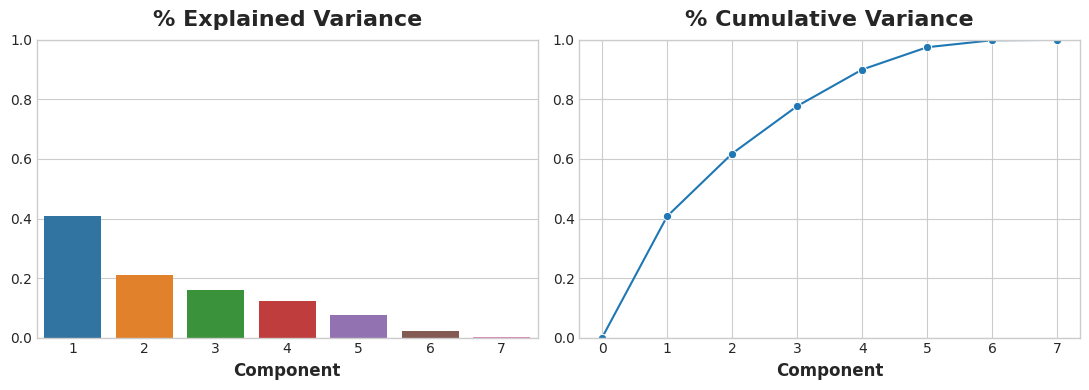

In [20]:
from sklearn.decomposition import PCA

# Standardize with StandardScaler
scaler = StandardScaler()
X_scaled_pca = scaler.fit_transform(df[features_weather])

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled_pca)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names, index=df.index)

# Create loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=df[features_weather].columns,
)

# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
evr = pca.explained_variance_ratio_
sns.barplot(x=grid, y=evr, ax=axs[0])
axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))

# Cumulative Variance
cum_variance = np.cumsum(evr)
sns.lineplot(x=np.r_[0, grid], y=np.r_[0, cum_variance], marker="o", ax=axs[1])
axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))

# Set up figure
fig.tight_layout()

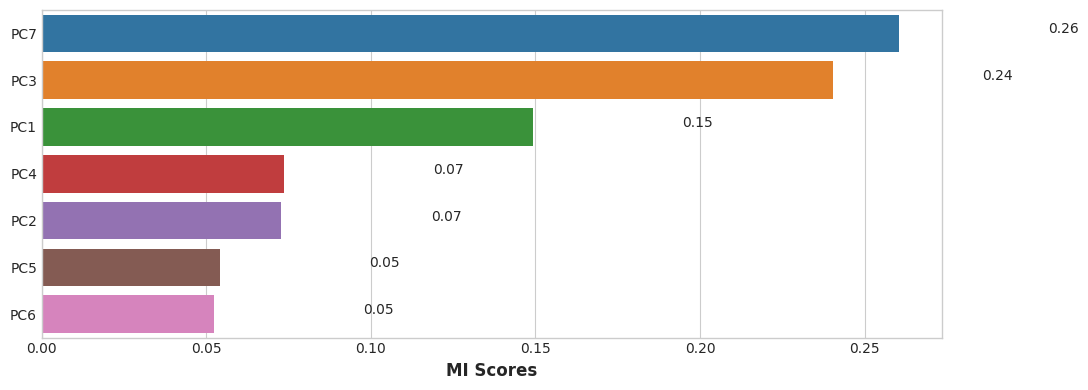

In [21]:
mi_scores = make_mi_scores(X_pca, df["GHI"])
plot_scores(mi_scores, "Mutual Information Scores")

The principals components 7, 3 then 1 explains the most the dataset

## Time series split
Otherwise the time index is not respected, the lines are randomly shuffled

In [22]:
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object for cross-validation
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit
cv = TimeSeriesSplit(
    n_splits=3,
    gap=0, #Number of samples to exclude from the end of each train set before the test set.
    #max_train_size=10000, #    Maximum size for a single training set.
    #test_size=1000, #Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed value with gap=0.
)

# concatenate final features in the same X, select below
X = pd.concat([X_leads, X_days, y_lags, X_lags_mean, df["Temperature"]], axis=1).dropna() #df[features_astronomical] in X_leads

# Align y with X on the index (row labels) and unpack the aligned objects back into y and X.
y, X = y.align(X, axis=0, join='inner') # inner avoid na values on axis

X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104821 entries, 2017-01-04 00:00:00 to 2019-12-31 21:00:00
Data columns (total 54 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   (y_lead_11, sin_solar_altitude)  104821 non-null  float64
 1   (y_lead_11, cos_solar_altitude)  104821 non-null  float64
 2   (y_lead_11, daylight)            104821 non-null  float64
 3   (y_lead_10, sin_solar_altitude)  104821 non-null  float64
 4   (y_lead_10, cos_solar_altitude)  104821 non-null  float64
 5   (y_lead_10, daylight)            104821 non-null  float64
 6   (y_lead_9, sin_solar_altitude)   104821 non-null  float64
 7   (y_lead_9, cos_solar_altitude)   104821 non-null  float64
 8   (y_lead_9, daylight)             104821 non-null  float64
 9   (y_lead_8, sin_solar_altitude)   104821 non-null  float64
 10  (y_lead_8, cos_solar_altitude)   104821 non-null  float64
 11  (y_lead_8, daylight)           

# Features selection

In [23]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate
#from sklearn.multioutput import MultiOutputRegressor # direct strategy, one model per time step
from sklearn.multioutput import RegressorChain #Direct Recursive strategy, capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

X_features = pd.concat([df[features_astronomical], df[features_weather], y_lags, X_leads, X_days, X_years, X_lags_mean, Xy["Cluster"], X_cd, X_pca], axis=1).dropna()

# Create a list of feature sets to evaluate
feature_sets = {
    "humidity":  y_lags.columns.tolist() + ["Relative Humidity"],
    "temperature":  y_lags.columns.tolist() + ["Temperature"],
    "humi temp dew point":  y_lags.columns.tolist() + ["Relative Humidity", "Temperature", "Dew Point"],
    "weather":  y_lags.columns.tolist() + df[features_weather].columns.tolist(),
    "PCA 3": y_lags.columns.tolist() + X_pca[["PC7", "PC3", "PC1"]].columns.tolist(),
    "PCA first 3": y_lags.columns.tolist() + X_pca[["PC1", "PC2", "PC3"]].columns.tolist(),
    "PCA all": y_lags.columns.tolist() + X_pca.columns.tolist(),
    "clusters distance": y_lags.columns.tolist() + X_cd.columns.tolist(),
    "clusters label": y_lags.columns.tolist() + ["Cluster"],
    "days": y_lags.columns.tolist() + X_days.columns.tolist(),
    "years": y_lags.columns.tolist() + X_years.columns.tolist(),
    "features_astronomical": y_lags.columns.tolist() + df[features_astronomical].columns.tolist(),
    "y_lags only": y_lags.columns.tolist(),
    "X_leads": y_lags.columns.tolist() + X_leads.columns.tolist(),
    "X_lags_mean": y_lags.columns.tolist() + X_lags_mean.columns.tolist(),
    "X": X.columns.tolist(),
}

# Create an empty DataFrame to store the scores
scores_features = pd.DataFrame()

# Iterate over the feature sets
for name, features_select in tqdm(feature_sets.items()):
    print(name)
    
    # Select the features
    X_try = X_features[features_select].dropna()

    # Align the target variable with the selected features
    y_try, X_try = y.align(X_try, axis=0, join='inner')

    # Evaluate the model
    cv_results = cross_validate(RegressorChain(LGBMRegressor(verbose=0, n_jobs=-1, random_state=0)), 
                                X_try.values, y_try.values, cv=cv, 
                                scoring=['neg_mean_absolute_error', 
                                         'neg_root_mean_squared_error', 
                                         #'max_error', # Multioutput not supported in max_error
                                         'r2'],
                                #https://scikit-learn.org/stable/modules/model_evaluation.html
                                n_jobs=-1,
                               )

    new_scores = pd.DataFrame(cv_results)
    new_scores['Features'] = name

    # Concatenate the new DataFrame with the existing one
    scores_features = pd.concat([scores_features, new_scores], ignore_index=True)

scores_features.groupby("Features").mean().sort_values('test_neg_root_mean_squared_error', ascending=False)

  0%|          | 0/16 [00:00<?, ?it/s]

humidity


  6%|▋         | 1/16 [00:42<10:33, 42.26s/it]

temperature


 12%|█▎        | 2/16 [01:21<09:27, 40.54s/it]

humi temp dew point


 19%|█▉        | 3/16 [02:04<09:03, 41.79s/it]

weather


 25%|██▌       | 4/16 [02:55<09:03, 45.26s/it]

PCA 3


 31%|███▏      | 5/16 [03:38<08:09, 44.51s/it]

PCA first 3


 38%|███▊      | 6/16 [04:21<07:17, 43.79s/it]

PCA all


 44%|████▍     | 7/16 [05:12<06:56, 46.28s/it]

clusters distance


 50%|█████     | 8/16 [05:55<06:02, 45.33s/it]

clusters label


 56%|█████▋    | 9/16 [06:34<05:03, 43.30s/it]

days


 62%|██████▎   | 10/16 [07:14<04:13, 42.22s/it]

years


 69%|██████▉   | 11/16 [07:55<03:28, 41.78s/it]

features_astronomical


 75%|███████▌  | 12/16 [08:35<02:45, 41.27s/it]

y_lags only


 81%|████████▏ | 13/16 [09:11<01:59, 39.83s/it]

X_leads


 88%|████████▊ | 14/16 [10:38<01:48, 54.08s/it]

X_lags_mean


 94%|█████████▍| 15/16 [11:21<00:50, 50.71s/it]

X


100%|██████████| 16/16 [13:01<00:00, 48.84s/it]


fit_time  score_time  test_neg_mean_absolute_error  \
Features                                                                     
X                      81.259303    2.659558                    -37.379062   
X_leads                69.138990    2.658174                    -38.301231   
days                   30.791836    2.586120                    -45.317187   
features_astronomical  31.515428    2.549978                    -59.887096   
years                  32.073409    2.571303                    -65.893564   
X_lags_mean            33.697019    2.621084                    -67.046012   
clusters distance      34.168505    2.567360                    -69.493897   
PCA all                40.549921    2.493117                    -70.005790   
temperature            30.105127    2.672771                    -70.946313   
PCA first 3            33.410658    2.523869                    -71.208495   
clusters label         29.954658    2.695190                    -71.836230   
PCA 3                  33.508471    2.602523                    -72.856622   
weather                39.780330    2.592779                    -72.331501   
y_lags only            27.876867    2.733663                    -71.666543   
humidity               30.367677    2.736849                    -72.811704   
humi temp dew point    33.821851    2.655362                    -73.445988   

                       test_neg_root_mean_squared_error   test_r2  
Features                                                           
X                                            -75.858295  0.865166  
X_leads                                      -77.245351  0.859741  
days                                         -82.312153  0.838131  
features_astronomical                        -91.088560  0.790800  
years                                        -95.705882  0.772735  
X_lags_mean                                  -96.555440  0.767187  
clusters distance                            -97.346492  0.758202  
PCA all                                      -99.005881  0.751949  
temperature                                  -99.328407  0.750182  
PCA first 3                                 -100.014893  0.746030  
clusters label                              -100.599986  0.741527  
PCA 3                                       -101.184960  0.739155  
weather                                     -101.320653  0.739436  
y_lags only                                 -101.852397  0.735396  
humidity                                    -102.335531  0.732476  
humi temp dew point                         -102.407563  0.732422

## Model selection

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR #support-vector machine
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor #gradient boost
from xgboost import XGBRegressor #gradient boost
from catboost import CatBoostRegressor #gradient boost
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import RegressorChain #Direct Recursive strategy, capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

# Create a dictionary of models to benchmark
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'DecisionTreeRegressor' : DecisionTreeRegressor(),
    'Support Vector Regression': RegressorChain(SVR()), #too long with large horizon
    'Random Forest Regression': RandomForestRegressor(), #too long with large horizon
    'HistGradientBoostingRegressor': RegressorChain(HistGradientBoostingRegressor()), #suitable for large dataset
    'LGBMRegressor' : RegressorChain(LGBMRegressor(verbose=0, n_jobs=-1)),
    'XGBRegressor' : RegressorChain(XGBRegressor()),
    'CatBoostRegressor': RegressorChain(CatBoostRegressor(verbose=False)),
    'MLPRegressor': MLPRegressor(max_iter=500), #neural network
}

# Placeholder for the scores
results_list = []

# Iterate over the models
for name, model in tqdm(models.items()):
    print(name)
    
    # Bundle preprocessing and modeling code in a pipeline
    pipeline = Pipeline(steps=[
                          ('scaler', StandardScaler()),  # the first step is to scale the data
                          ("model", model),
                        ]
                  )

    # Evaluate the model
    cv_results = cross_validate(pipeline, X.values, y.values, cv=cv, 
                                scoring=['neg_mean_absolute_error', 
                                         'neg_root_mean_squared_error', 
                                         #'max_error', # Multioutput not supported in max_error
                                         'r2'],
                                #https://scikit-learn.org/stable/modules/model_evaluation.html
                                n_jobs=-1,
                               )

    # Collect results
    new_scores = pd.DataFrame(cv_results)
    new_scores['Model'] = name
    results_list.append(new_scores)

# Concatenate all results into a single DataFrame
scores_algos = pd.concat(results_list, ignore_index=True)

# Group by Model and calculate mean scores
mean_scores = scores_algos.groupby("Model").mean()

# Sort by RMSE
mean_scores.sort_values('test_neg_root_mean_squared_error', ascending=False)

  0%|          | 0/12 [00:00<?, ?it/s]

Linear Regression


  8%|▊         | 1/12 [00:01<00:14,  1.34s/it]

Ridge Regression


 17%|█▋        | 2/12 [00:02<00:09,  1.06it/s]

Lasso Regression


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+05, tolerance: 1.429e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e+05, tolerance: 2.483e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.078e+05, tolerance: 3.545e

Elastic Net


 33%|███▎      | 4/12 [02:10<05:19, 39.89s/it]

DecisionTreeRegressor


 42%|████▏     | 5/12 [02:18<03:18, 28.41s/it]

Support Vector Regression


 50%|█████     | 6/12 [8:03:46<16:24:03, 9840.58s/it]

Random Forest Regression


 58%|█████▊    | 7/12 [8:08:06<9:19:01, 6708.28s/it] 

HistGradientBoostingRegressor


 67%|██████▋   | 8/12 [8:08:50<5:05:46, 4586.71s/it]

LGBMRegressor


 75%|███████▌  | 9/12 [8:10:50<2:39:31, 3190.47s/it]

XGBRegressor


 83%|████████▎ | 10/12 [8:12:22<1:14:28, 2234.01s/it]

CatBoostRegressor


 92%|█████████▏| 11/12 [8:24:18<29:29, 1769.33s/it]  

MLPRegressor


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 12/12 [8:27:53<00:00, 2539.49s/it]


fit_time   score_time  \
Model                                                      
MLPRegressor                     143.756993     0.061811   
CatBoostRegressor                610.229666    19.782886   
LGBMRegressor                     96.146573     2.613933   
HistGradientBoostingRegressor     29.498292     4.013953   
Random Forest Regression         177.408588     0.581275   
XGBRegressor                      65.505567     1.285977   
Linear Regression                  0.752675     0.054942   
Ridge Regression                   0.337345     0.050736   
Lasso Regression                  66.213665     0.049809   
Elastic Net                       23.354711     0.055339   
DecisionTreeRegressor              5.907085     0.050339   
Support Vector Regression      13651.231998  2092.754325   

                               test_neg_mean_absolute_error  \
Model                                                         
MLPRegressor                                     -35.699281   
CatBoostRegressor                                -35.424009   
LGBMRegressor                                    -37.246384   
HistGradientBoostingRegressor                    -38.038452   
Random Forest Regression                         -35.892219   
XGBRegressor                                     -37.998406   
Linear Regression                                -46.055888   
Ridge Regression                                 -46.130110   
Lasso Regression                                 -47.093252   
Elastic Net                                      -54.750125   
DecisionTreeRegressor                            -46.834006   
Support Vector Regression                        -54.499124   

                               test_neg_root_mean_squared_error   test_r2  
Model                                                                      
MLPRegressor                                         -72.661208  0.877529  
CatBoostRegressor                                    -74.696114  0.869972  
LGBMRegressor                                        -75.767718  0.865503  
HistGradientBoostingRegressor                        -76.085678  0.864216  
Random Forest Regression                             -76.471581  0.863878  
XGBRegressor                                         -78.721999  0.854856  
Linear Regression                                    -80.114951  0.849862  
Ridge Regression                                     -80.125881  0.849802  
Lasso Regression                                     -81.007489  0.846552  
Elastic Net                                          -89.220416  0.816544  
DecisionTreeRegressor                               -108.478174  0.728383  
Support Vector Regression                           -110.941395  0.691312

# Parameters tuning

In [25]:
### WARNING: been disabled in new docker images
# Load the extension and start TensorBoard
#https://www.kaggle.com/code/aagundez/using-tensorboard-in-kaggle-kernels/notebook

#%load_ext tensorboard
#%tensorboard --logdir logs

# Configure the TensorBoard callback and fit your model
#import tensorflow as tf
#tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.multioutput import RegressorChain #Direct Recursive stragety, capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#https://lightgbm.readthedocs.io/en/latest/Features.html
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_refit_callable.html
#https://scikit-learn.org/stable/modules/grid_search.html
pipeline = Pipeline(steps=[
                      ('scaler', StandardScaler()),  # the first step is to scale the data
                      ("clf", RegressorChain(LGBMRegressor(verbose=-1)))
])


param_grid = {
    #https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    #num_leaves = 2^(max_depth)
    "clf__base_estimator__num_leaves": [36, 50, 64, 75, 100, 144, 225, 500],  # when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth)
    "clf__base_estimator__min_data_in_leaf": [10, 100, 250, 500, 750, 1000],  # Set to prevent overfitting
    #"clf__base_estimator__max_depth": [6, 8, 10, 12, 15, 20]  # Limited depths to balance complexity and overfitting
    #"clf__base_estimator__learning_rate": [0.01, 0.1, 1],
    #"clf__base_estimator__subsample": [0.5, 0.8, 1]
}


grid = GridSearchCV(pipeline, 
                    param_grid=param_grid, 
                    cv=cv, 
                    n_jobs=-1,  # Use all available cores
                    verbose=1, 
                    scoring=[
                        'neg_mean_absolute_error', 
                        'neg_root_mean_squared_error', 
                        # 'max_error', # Multioutput not supported in max_error
                        'r2',
                            ],
                    refit='neg_root_mean_squared_error', # fit with RMSE
                   )

%time grid.fit(X.values, y.values)

print("best_score_ :", grid.best_score_, "RMSE")
print("grid.best_params_ :", grid.best_params_) #min_data_in_leaf=500, num_leaves=64

Fitting 3 folds for each of 48 candidates, totalling 144 fits
CPU times: user 2min 14s, sys: 17.1 s, total: 2min 31s
Wall time: 2h 36min 23s
best_score_ : -74.97977219939462 RMSE
grid.best_params_ : {'clf__base_estimator__min_data_in_leaf': 500, 'clf__base_estimator__num_leaves': 50}


In [27]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RegressorChain(base_estimator=LGBMRegressor(min_data_in_leaf=500,
                                                             num_leaves=50,
                                                             verbose=-1)))])

# Plot prediction
## Train model with select features

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor # direct strategy, one model per time step
from sklearn.multioutput import RegressorChain #Direct Recursive stragety, capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.


# Bundle preprocessing and modeling code in a pipeline
#pipeline = Pipeline(steps=[
#                      ('scaler', StandardScaler()),  # the first step is to scale the data
#                      ("model", RegressorChain(LGBMRegressor(n_jobs=-1, min_data_in_leaf=500, num_leaves=64)))
#                    ])
pipeline = grid.best_estimator_

# Find the index of the last sample in the training set
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing

# Split the data into training and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

%time pipeline.fit(X_train.values, y_train.values)

y_fit = pd.DataFrame(pipeline.predict(X_train.values), 
                     index=X_train.index, 
                     columns=y.columns)
y_pred = pd.DataFrame(pipeline.predict(X_test.values), 
                      index=X_test.index, 
                      columns=y.columns)

from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

CPU times: user 1min 13s, sys: 0 ns, total: 1min 13s
Wall time: 1min 14s
Train RMSE: 75.10
Test RMSE: 77.22


# Plot predictions with best features and parameters

In [29]:
import plotly.express as px
px.line(df['GHI'].iloc[split_index:])

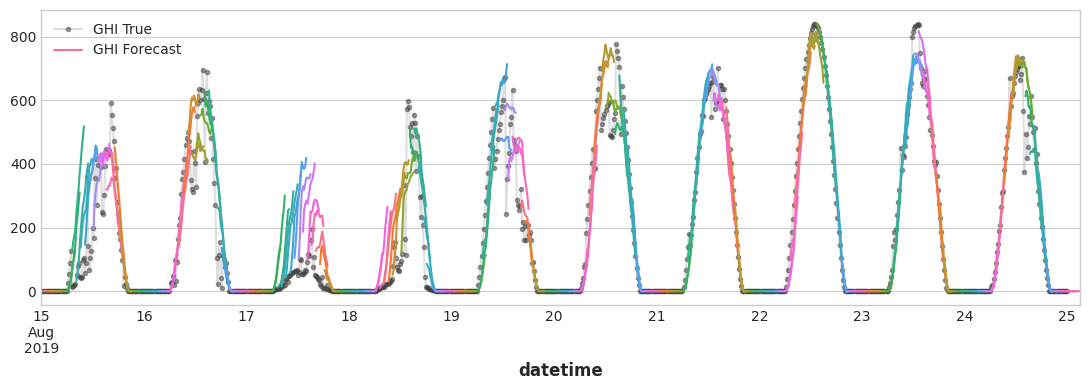

In [30]:
START = '2019-08-15 00:00:00'
STOP = '2019-08-25 00:00:00'

EVERY = ONE_HOUR #plot every

y_ = pd.DataFrame(df['GHI'].loc[START:STOP], columns=["GHI"])
y_pred_ = y_pred.loc[START:STOP]

fig, ax = plt.subplots()
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)

palette_kwargs_ = dict(palette="husl", n_colors=16, desat=None)
palette = sns.color_palette(**palette_kwargs_)

# Set the color cycle for the subplot
ax.set_prop_cycle(plt.cycler("color", palette))
# Loop through the rows of the DataFrame, with a step size of every
for date, preds in y_pred_[::EVERY].iterrows():

    # Set the index of the predictions to be a range of periods, starting from the date
    preds.index = pd.period_range(start=date, periods=len(preds), freq=pd.infer_freq(y_pred_.index)) 
    # Plot the predictions on the subplot
    ax = preds.plot(ax=ax)
_ = ax.legend(["GHI True", "GHI" + ' Forecast'])

# SHAP (SHapley Additive exPlanations)
explain the output of the machine learning model

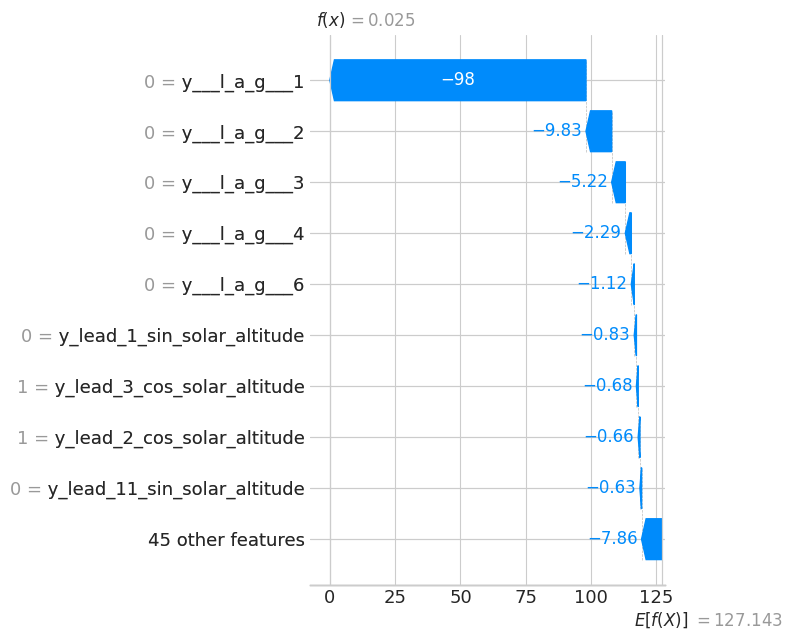

In [31]:
# Access the RegressorChain instance using its index in the pipeline
regressor_chain = pipeline.steps[1][1]  # '1' because it's the second step in the pipeline

# Access the base_estimator (LGBMRegressor)
base_estimator = regressor_chain.base_estimator

import shap

X_flat = X.copy() #shap can not manage multi-index columns, convert to single level
X_flat.columns = ['_'.join(map(str, col)).strip() for col in X_flat.columns.values]

# Fit the model if it hasn't been already
if not hasattr(base_estimator, "feature_importances_"):
    base_estimator.fit(X.values, y.iloc[:,0].values) #acces only to the first column.
    #=> analyse only on the next time step
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(base_estimator)
shap_values = explainer(X_flat)
# Return the SHAP values and a waterfall plot for the first instance
shap.plots.waterfall(shap_values[0])

From: https://github.com/shap/shap

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. 

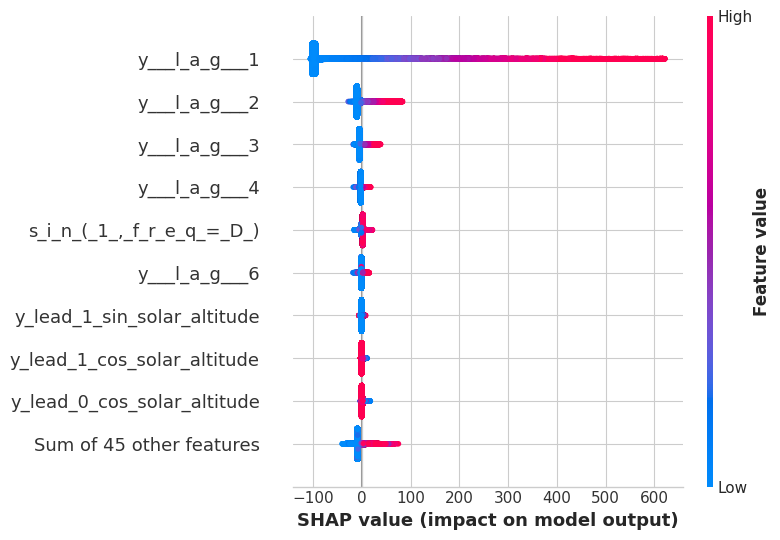

In [32]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

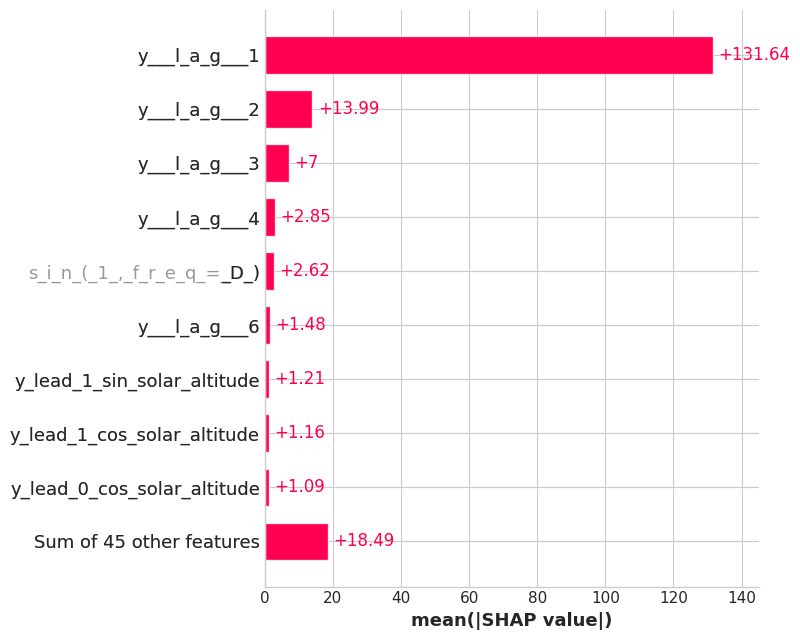

In [33]:
shap.plots.bar(shap_values)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):